## The two excel sheets were extracted from the campaign_finance_reports.mdb file. Specifically, the Master and Receipts tables were used, since the receipts table contained the contributor details and the master table contained the details of the people/entities that received the contributions

In [3]:
import pandas as pd
import os
from fuzzywuzzy import fuzz
import time

In [6]:
mst = pd.read_excel('./access_data/master.xlsx')
rpt = pd.read_excel('./access_data/receipts.xlsx')

## Performing a merge of the two dataframes based on Report_ID

In [7]:
joined_df = rpt.merge(mst[['Report_ID','Full_Name','Comm_Name','Report_Year','CPF_ID','Filing_Date']], on=('Report_ID'), suffixes=('_l','_r'), validate="m:1")

In [8]:
updated_df = joined_df.drop('Principal_Officer',axis=1)

In [9]:
updated_df.to_csv('updated_df.csv')

## Initializing the keywords we will use for filtering. 

### The pac_keywords.txt file contains all the relevant PAC names
### The occupation_keywords.txt contains all the keywords for occupation filtering
### The employer_keywords.txt contains all the keywords for employer filtering
### The type_keywords.txt contains all the keywords for business type filtering in the PDF data

In [4]:
updated_df = pd.read_csv('updated_df.csv')

In [20]:
suffix = '_healthcare.txt' #Use this to append a suffix to the keywords file

In [21]:
def get_data(f_name):
    arr = []
    f = open(os.path.join('./keywords', f_name + suffix), 'r')
    for line in f:
        arr.append(line.strip(' \n').lower().split('inc.')[0].split('llc')[0].strip(' ,'))
    f.close()
    return arr
occupation = get_data('occupation_keywords')
employer = get_data('employer_keywords')
type_words = get_data('type_keywords')
pacs = get_data('pac_keywords')
hospitals = get_data('hospital_keywords')
suppliers = get_data('supplier_keywords')
# occupation = ['Nurse','Doctor','Physician','MD','Medical','Hospital','Clinical','RN','Health','Patient', 'Medicine']
# employer = ['Hospital','Health','Healthcare','Medical']
# type_words = ['Hospital', 'Health', 'Healthcare','Medical', 'Medicine', 'Clinic', 'Doctor', 'Nurse', 'Patient', 'Medic']
# pacs = ['CVS Health Massachusetts Political Action Committee', 'MA Association of Community Health PAC', \
#         'MA Pol Action Comm for Radiological Health Care', 'Massachusetts Health and Hospital Association Political Action Committee (MHAPAC)',\
#        'Tenet Healthcare Corporation Political Action Committee Massachusetts']

## Reading the business types of each of the companies in the Sec. State PDF data

In [22]:
def check_type(df_val):
    if type(df_val) != str:
        return False
    df_val = df_val.lower()
    for i in type_words:
        i = i.lower()
        if i in df_val or df_val in i:
            return True
    return False

In [23]:
import os
b_names = []
types = pd.read_csv('../../business_types.csv').dropna()
for name in types[types['Type'].apply(check_type) == True]['Name'].to_numpy():
    b_names.append(name)
for root, dirs, files in os.walk("../../n_z_types/", topdown=False):
    for i in files:
        if 'xlsx' in i:
            types = pd.read_excel(os.path.join(root, i),encoding = "ISO-8859-1", header=None).dropna()
        else:
            types = pd.read_csv(os.path.join(root,i),encoding = "ISO-8859-1", header=None).dropna()
        for name in types[types[1].apply(check_type) == True][0].to_numpy():
            b_names.append(name)

In [24]:
print(len(b_names))

15997


## Filtering the business names according to keywords

In [25]:
filtered_business_names = []
for i in b_names:
    flag = 0
    for w in type_words:
        if w.lower() in i.split(',')[0].split('LLC')[0].strip(' ').lower():
            flag = 1
            break
    if flag == 0:
        filtered_business_names.append(i.split(',')[0].split('LLC')[0].strip(' \n').lower())

In [26]:
for i in hospitals:
    filtered_business_names.append(i)
for i in suppliers:
    filtered_business_names.append(i)
print(len(filtered_business_names))

12102


In [98]:
def check_occ(df_val, ignore=None):
    if type(df_val) != str:
        return False
    if ignore != None:
        for x in ignore:
            if x in df_val:
                return False
    for x in occupation:
        if x != "MD" and x != "RN":
            x = x.lower()
            df_val = df_val.lower()
        if x in df_val:
            return True
    return False
def check_emp(df_val, ignore=['hospitality']):
    if type(df_val) != str:
        return False
    df_val = df_val.lower()
    if ignore != None:
        for x in ignore:
            if x in df_val:
                return False
    for x in employer:
        x = x.lower()
        if x in df_val:
            return True
    return False
def check_pacs(df_val, ignore=None):
    if type(df_val) != str:
        return False
    df_val = df_val.lower()
    if ignore != None:
        for x in ignore:
            if x in df_val:
                return False
    for x in pacs:
        x = x.lower()
        r = fuzz.ratio(x, df_val)
        if r >= 90:
#             print(x, df_val)
            return True
    return False
def check_names(df_val, ignore=None):
    if type(df_val) != str:
        return False
    df_val = df_val.split(',')[0].split('LLC')[0].strip(' \n').lower()
    if ignore != None:
        for x in ignore:
            if x in df_val:
                return False
    for x in filtered_business_names:
        r = fuzz.ratio(x, df_val)
        if r >= 90:
#             print(x, df_val)
            return True
    return False

## Filtering the dataframe according to the keywords and the business names

In [30]:
import pickle
f = open('emp_names.pkl', 'rb')
emp_names = pickle.load(f)
f.close()

In [32]:
updated_df.columns

Index(['Unnamed: 0', 'ID', 'Report_ID', 'Date', 'Contributor_Type',
       'First_Name', 'Last_Name', 'Address', 'City', 'State', 'Zip',
       'Occupation', 'Employer', 'Contributor_ID', 'Amount', 'Full_Name',
       'Comm_Name', 'Report_Year', 'CPF_ID', 'Filing_Date'],
      dtype='object')

In [99]:
recipient_medical = updated_df['Full_Name'].apply(check_occ)
donor_medical = updated_df['Employer'].apply(check_occ)
occupations_filter = updated_df['Occupation'].apply(check_occ)
last_name_occ = updated_df['Last_Name'].apply(check_occ)

employer_filter = updated_df['Employer'].apply(check_emp)
occ_employer = updated_df['Occupation'].apply(check_emp)
employer_recipient = updated_df['Full_Name'].apply(check_emp)
donor_employer = updated_df['Last_Name'].apply(check_emp)

In [52]:
recipient_pacs = updated_df['Full_Name'].apply(check_pacs)
donor_pacs = updated_df['Last_Name'].apply(check_pacs)
employer_pacs = updated_df['Employer'].apply(check_pacs)

In [ ]:
emp_names = updated_df['Employer'].apply(check_names)

In [ ]:
filtered_df = updated_df[recipient_medical | 
                         donor_medical | 
                         occupations_filter | 
                         last_name_occ | 
                         employer_filter | 
                         occ_employer | 
                         recipient_pacs | 
                         donor_pacs | 
                         employer_pacs | emp_names |
                         ((updated_df['Contributor_Type'] != 'Individual') & (updated_df['Last_Name'].apply(check_names) == True))]

In [104]:
filtered_df.shape

(282111, 20)

In [115]:
filtered_df

,Unnamed: 0,ID,Report_ID,Date,Contributor_Type,First_Name,Last_Name,Address,City,State,Zip,Occupation,Employer,Contributor_ID,Amount,Full_Name,Comm_Name,Report_Year,CPF_ID,Filing_Date
2,2,11308880,558097,2016-01-03,Individual,Ernest,Correia,68720 Paseo Real,Cathedral City,CA,92234,Retired,Electrician,NaN,100.0,Shaynah Barnes,Barnes Committee,2016,15953,2016-01-03 01:27:06.463
3,3,11308881,558097,2016-01-03,Individual,Kenneth,Williams,180,Bridgewater,MA,02324,Retired,DHL EXPRESS,NaN,30.0,Shaynah Barnes,Barnes Committee,2016,15953,2016-01-03 01:27:06.463
5,5,11309689,558168,2016-01-04,Individual,Emily,Cook,123 Maynard Farm Road,Sudbury,MA,01776,Podiatrist,Self,NaN,100.0,MA Podiatric PAC,MA Podiatric PAC,2016,80702,2016-01-04 09:09:47.027
6,6,11309690,558168,2016-01-04,Individual,Anthony,Sarage,176 Inverness Lane,Longmeadow,MA,01116,Podiatrist,Self Employed,NaN,100.0,MA Podiatric PAC,MA Podiatric PAC,2016,80702,2016-01-04 09:09:47.027
9,9,11309299,558123,2016-01-03,Individual,Christine,Canavan,23 Tucker Terrace,Raynham,MA,02767,Retired,State Representative,NaN,120.0,Shaynah Barnes,Barnes Committee,2016,15953,2016-01-03 16:06:02.790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042693,1042693,13698322,731282,2020-02-19,Individual,MAUREEN,MARTELL,12 PURCELL DRIVE,CHELMSFORD,NaN,NaN,HEALTH PROFESSIONAL,TEAMSTERSCARE,NaN,4.0,Chapter 25 Associated the Nat'l DRIVE PAC of t...,Chapter 25 Associated the Nat'l DRIVE PAC of t...,2020,80220,2020-02-19 16:07:54.823
1042694,1042694,13698323,731282,2020-02-19,Individual,JANET,DESSIE,27 LINDEN ST,SOMERVILLE,NaN,NaN,HEALTH PROFESSIONAL,TEAMSTERSCARE,NaN,2.0,Chapter 25 Associated the Nat'l DRIVE PAC of t...,Chapter 25 Associated the Nat'l DRIVE PAC of t...,2020,80220,2020-02-19 16:07:54.823
1042695,1042695,13698324,731282,2020-02-19,Individual,LARRY,LIBBY JR,371 BOSTON RD,BILLERICA,NaN,NaN,HEALTH PROFESSIONAL,TEAMSTERSCARE,NaN,20.0,Chapter 25 Associated the Nat'l DRIVE PAC of t...,Chapter 25 Associated the Nat'l DRIVE PAC of t...,2020,80220,2020-02-19 16:07:54.823
1042792,1042792,13698423,731296,2020-02-19,Individual,Thomas,Steriti,90 Emerald Dr.,Lynn,MA,01904,Lab Technician,Northeastern University,NaN,5.0,Richard F. Canavan-Wagner,Canavan-Wagner Committee,2020,17277,2020-02-19 18:33:00.973


## Saving the final filtered dataframe to a csv file

In [106]:
filtered_df.to_csv('output_2.csv')

## Here we analyze the ranges of the contributions and draw a simple bar graph based on the results

In [121]:
l = {'0-25':0,'25-100':0,'101-1000':0,'1001-10000':0,'10001-100000':0,'100001-1000000':0,'1000001+':0}
for index, row in filtered_df.iterrows():
    amt = row['Amount']
    if amt <= 25:
        l['0-25'] += 1
    elif amt >= 25 and amt <= 100:
        l['25-100'] += 1
    elif amt > 100 and amt <= 1000:
        l['101-1000'] += 1
    elif amt > 1000 and amt <= 10000:
        l['1001-10000'] += 1
    elif amt > 10000 and amt <= 100000:
        l['10001-100000'] += 1
    elif amt > 100000 and amt <= 1000000:
        l['100001-1000000'] += 1
    else:
        l['1000001+'] += 1

In [118]:
l_2 = {'0-25':0,'25-100':0,'101-1000':0,'1001-10000':0,'10001-100000':0,'100001-1000000':0,'1000001+':0}
for index, row in updated_df.iterrows():
    amt = row['Amount']
    if amt <= 25:
        l_2['0-25'] += 1
    elif amt >= 25 and amt <= 100:
        l_2['25-100'] += 1
    elif amt > 100 and amt <= 1000:
        l_2['101-1000'] += 1
    elif amt > 1000 and amt <= 10000:
        l_2['1001-10000'] += 1
    elif amt > 10000 and amt <= 100000:
        l_2['10001-100000'] += 1
    elif amt > 100000 and amt <= 1000000:
        l_2['100001-1000000'] += 1
    else:
        l_2['1000001+'] += 1

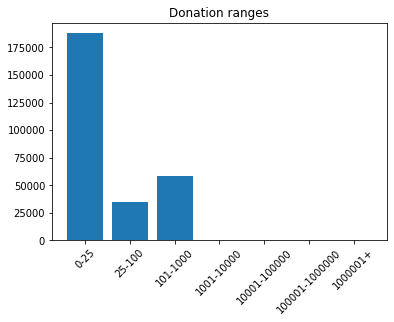


Calculated ranges
{'0-25': 187817, '25-100': 35100, '101-1000': 58236, '1001-10000': 701, '10001-100000': 185, '100001-1000000': 62, '1000001+': 10}


In [123]:
import matplotlib.pyplot as plt
plt.bar(list(l), l.values())
plt.xticks(list(l), rotation='45')
plt.title('Donation ranges')
plt.show()
# print("Highest contributor - " + str(m_i))
print("\nCalculated ranges")
print(l)

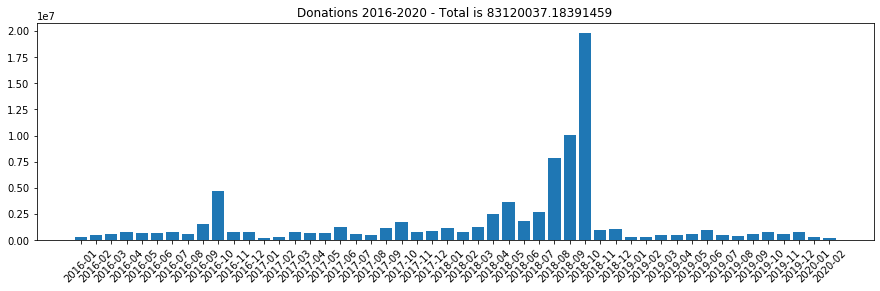

In [126]:
amounts = filtered_df['Amount'].to_numpy()
dates = filtered_df['Date'].to_numpy()
amount_dict = {}
total = 0
for i in range(len(dates)):
    date_sub = dates[i].split('-')[0] + '-' + dates[i].split('-')[1]
    if date_sub not in amount_dict:
        amount_dict[date_sub] = 0
    total += float(amounts[i])
    amount_dict[date_sub] += float(amounts[i])
x = []
y = []
vals = list(amount_dict)
def custom_sort(a):
    return int(a.split('-')[0]) * 100 + int(a.split('-')[1])
x = sorted(vals, key=custom_sort)
for i in x:
    y.append(amount_dict[i])
plt.figure(1, figsize=(15, 4))
plt.bar(x, y)
plt.xticks(x, rotation='45')
plt.title('Donations 2016-2020 - Total is ' + str(total))
plt.show()

In [132]:
filtered_df[filtered_df['Date'].str.contains('2018-09')].sort_values(['Amount'], ascending=False)[:20]

,Unnamed: 0,ID,Report_ID,Date,Contributor_Type,First_Name,Last_Name,Address,City,State,Zip,Occupation,Employer,Contributor_ID,Amount,Full_Name,Comm_Name,Report_Year,CPF_ID,Filing_Date
593053,593053,12917154,677154,2018-09-12,OTHER,NaN,Massachusetts Health & Hospital Association,500 District Ave,Burlington,MA,01803,NaN,NaN,NaN,2400000.00,Coalition to Protect Patient Safety,Coalition to Protect Patient Safety,2018,95455,2018-11-05 13:58:56.653
562699,562699,12825943,673113,2018-09-26,OTHER,NaN,Massachusetts Health & Hospital Association,500 District Ave,Burlington,MA,01803,NaN,NaN,NaN,1300000.00,Coalition to Protect Patient Safety,Coalition to Protect Patient Safety,2018,95455,2018-10-05 17:16:30.120
626425,626425,12991712,684763,2018-09-11,OTHER,NaN,Massachusetts Nurses Association,340 Turnpike St.,Canton,MA,02021,NaN,NaN,NaN,1000000.00,Committee to Ensure Safe Patient Care,Committee to Ensure Safe Patient Care,2018,95450,2019-01-17 10:52:13.437
626529,626529,12992000,684780,2018-09-24,OTHER,NaN,Massachusetts Nurses Association,340 Turnpike St.,Canton,MA,02021,NaN,NaN,NaN,1000000.00,Committee to Ensure Safe Patient Care,Committee to Ensure Safe Patient Care,2018,95450,2019-01-17 11:08:07.813
593052,593052,12917150,677154,2018-09-05,OTHER,NaN,Massachusetts Health & Hospital Association,500 District Ave,Burlington,MA,01803,NaN,NaN,NaN,900000.00,Coalition to Protect Patient Safety,Coalition to Protect Patient Safety,2018,95455,2018-11-05 13:58:56.653
626531,626531,12992002,684780,2018-09-27,OTHER,NaN,Massachusetts Nurses Association,340 Turnpike St.,Canton,MA,02021,NaN,NaN,NaN,561063.39,Committee to Ensure Safe Patient Care,Committee to Ensure Safe Patient Care,2018,95450,2019-01-17 11:08:07.813
576686,576686,12862178,675424,2018-09-19,Individual,Laura and John,Arnold,1999 Bryan St Suite 900,Dallas,TX,75201,Owner,"Action Now Iniative, LLC",NaN,510000.00,Patients for Affordable Drugs Action Independe...,Patients for Affordable Drugs Action Independe...,2018,81000,2018-10-27 10:58:28.103
562700,562700,12825945,673113,2018-09-27,OTHER,NaN,Massachusetts Health & Hospital Association,500 District Ave,Burlington,MA,01803,NaN,NaN,NaN,500000.00,Coalition to Protect Patient Safety,Coalition to Protect Patient Safety,2018,95455,2018-10-05 17:16:30.120
561301,561301,12815531,672765,2018-09-21,OTHER,NaN,REPUBLICAN GOVERNORS ASSOCIATION,"1747 PENNSYLVANIA AVE., NW, SUITE 250",WASHINGTON,DC,20006,NaN,NaN,NaN,500000.00,Commonwealth Future Independent Expenditure Po...,Commonwealth Future Independent Expenditure Po...,2018,80920,2018-10-03 12:08:37.920
626530,626530,12992001,684780,2018-09-24,OTHER,NaN,Massachusetts Nurses Association Region 5,340 Turnpike St.,Canton,MA,02021,NaN,NaN,NaN,250000.00,Committee to Ensure Safe Patient Care,Committee to Ensure Safe Patient Care,2018,95450,2019-01-17 11:08:07.813
